## SimCLR v1 Architechture

### Inputs

In [2]:
# !pip install torchlars

In [3]:
# !pip install torch torchvision

In [4]:
# !pip install torchlars --no-cache-dir

In [5]:
# !git clone https://github.com/kakaobrain/torchlars.git
# %cd torchlars
# !python setup.py install

In [6]:
# from torchlars import LARS

In [1]:
# !pip install pytorch-lightning
# !pip install lightning-flash

In [1]:
!pip install pytorch-lightning==1.8.3.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

# from torchlars import LARS  # Optimizer
from flash.core.optimizers import LARS

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Model Settings

In [3]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# LOSS
TEMPERATURE = 0.5

# Other
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using : {DEVICE}")

GRAYSCALE = True

using : cpu


### ResNet50 - Base Encoder

In [132]:
from re import X
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        print(out.shape)
        out = self.bn1(out)
        print(out.shape)
        out = self.relu(out)

        out = self.conv2(out)
        print(out.shape)

        out = self.bn2(out)
        print(out.shape)
        out = self.relu(out)

        out = self.conv3(out)
        print(out.shape)
        out = self.bn3(out)
        print(out.shape)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.bn1(x)
        print(x.shape)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        x = self.layer4(x)
        print(x.shape)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        print(x.shape)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet50(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

In [4]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet50(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model

### MLP - Projection Head

In [133]:
# MLP - One Hidden Layer
hidden_layer = nn.Linear(2048, 512)
output_layer = nn.Linear(512, 128)
mlp = nn.Sequential(hidden_layer, 
                    nn.ReLU(), 
                    output_layer)


### SimCLR v1 - Model

In [16]:
# SimCLRv1 Model
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super(SimCLR, self).__init__()

        self.encoder = base_encoder
        self.projection_head = nn.Sequential(
            # self.encoder.fc.in_features à la place de 2048
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z = self.projection_head(h)
        return h, z


In [127]:
y = resnet50(10)
y = y(torch.randn(1, 1, 28, 28))
y

torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 7, 7])
torch.Size([1, 128, 7, 7])
torch.Size([1, 128, 7, 7])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size([1, 128, 4, 4])
torch.Size(

ValueError: ignored

In [17]:
torch.manual_seed(RANDOM_SEED)

resNet50 = resnet50(NUM_CLASSES)
resNet50 = list(resNet50.children())[:-1]
resNet50 = nn.Sequential(*resNet50)

SimCLRv1_model = SimCLR(resNet50)

SimCLRv1_model.to(DEVICE)


SimCLR(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [84]:
# import torchvision.models

# modelResnet50 = resnet50(10)
# modelResnet50.fc.in_features

### LARS - Optimizer

In [ ]:
# !pip install pytorch-lightning
# !pip install lightning-flash

In [18]:
from flash.core.optimizers import LARS

optimizer = LARS(
    SimCLRv1_model.parameters(),
    lr=0.1,
    weight_decay=1e-6,
    momentum=0.9
)

### NT-Xent - Constrative Loss
*normalized temperature-scaled cross entropy loss*

In [19]:
def NTXent_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss

## Data Augmentation

In [20]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True,
                                           transform=transforms.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root="./data", train=False,
                                          transform=transforms.ToTensor(), 
                                          download=True)

# Data augmentation transforms
transform_train1 = transforms.Compose([
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ElasticTransform(alpha=10.0),
])

transform_train2 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.7, p=1.0),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 4)),
])


# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)

torch.Size([128, 1, 28, 28]) tensor(3)


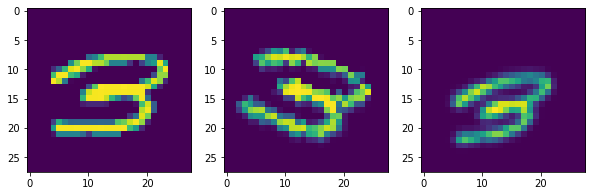

In [21]:
for index, (images, labels) in enumerate(train_loader):
    print(images.shape, labels[0])

    fig, ax = plt.subplots(1, 3, figsize = (10, 20))
    ax[0].imshow(images[0][0])
    ax[1].imshow(transform_train1(images)[0][0])
    ax[2].imshow(transform_train2(images)[0][0])
    plt.show()
    break

## Training Loop

In [22]:
for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        
        # images, labels and transformed images
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        transformedImg1 = transform_train1(images)
        transformedImg2 = transform_train2(images)

        # print(images.shape)
        # print(transformedImg1.shape)

        # FORWARD AND BACK PROP
        output1 = SimCLRv1_model(transformedImg1)
        
        output2 = SimCLRv1_model(transformedImg2)

        loss = NTXent_loss(output1, output2, TEMPERATURE)
        optimizer.zero_grad()
        
        loss.backward()
        
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        
        # LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), loss))
    break
            

torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 256, 7, 7])
torch.Size([128, 256, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 256, 7, 7])
torch.Size([128, 256, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 64, 7, 7])
torch.Size([128, 256, 7, 7])
torch.Size([128, 256, 7, 7])
torch.Size([128, 128, 7, 7])
torch.Size([128, 128, 7, 7])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 512, 4, 4])
torch.Size([128, 512, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 512, 4, 4])
torch.Size([128, 512, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 128, 4, 4])
torch.Size([128, 512, 4, 4

RuntimeError: ignored

## Full Code

In [14]:
# 1 - MODEL SETTINGS
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# LOSS
TEMPERATURE = 0.5

# Other
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using : {DEVICE}")

GRAYSCALE = True


# 2 - BASE ENCODER
from re import X
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        print(out.shape)
        out = self.bn1(out)
        print(out.shape)
        out = self.relu(out)

        out = self.conv2(out)
        print(out.shape)

        out = self.bn2(out)
        print(out.shape)
        out = self.relu(out)

        out = self.conv3(out)
        print(out.shape)
        out = self.bn3(out)
        print(out.shape)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.bn1(x)
        print(x.shape)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        x = self.layer4(x)
        print(x.shape)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        print(x.shape)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet50(num_classes):
    """Constructs a ResNet-50 model."""
    model = ResNet(block=Bottleneck, 
                   layers=[3, 4, 6, 3],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


# 3 - SIMCLR MODEL
# SimCLRv1 Model
class SimCLR(nn.Module):
    def __init__(self, base_encoder, projection_dim=128):
        super(SimCLR, self).__init__()

        self.encoder = base_encoder
        self.projection_head = nn.Sequential(
            # self.encoder.fc.in_features à la place de 2048
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return h, z


# 4 - LARS OPTIMIZER
from flash.core.optimizers import LARS

optimizer = LARS(
    SimCLRv1_model.parameters(),
    lr=0.1,
    weight_decay=1e-6,
    momentum=0.9
)

# 5 - NTXENT LOSS
def NTXent_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    # Full similarity matrix
    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    # Positive similarity
    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss


# 6 - DATA AUGMENTATION
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True,
                                           transform=transforms.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root="./data", train=False,
                                          transform=transforms.ToTensor(), 
                                          download=True)

# Data augmentation transforms
transform_train1 = transforms.Compose([
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.ElasticTransform(alpha=10.0),
])

transform_train2 = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.7, p=1.0),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 4)),
])


# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)


# 7 - TRAINING LOOP
for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        
        # images, labels and transformed images
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        transformedImg1 = transform_train1(images)
        transformedImg2 = transform_train2(images)

        #print(images.shape)
        #print(transformedImg1)
        
        # FORWARD AND BACK PROP
        output1 = SimCLRv1_model(transformedImg1)
        
        output2 = SimCLRv1_model(transformedImg2)

        loss = NTXent_loss(output1, output2, TEMPERATURE)
        optimizer.zero_grad()
        
        loss.backward()
        
        # UPDATE MODEL PARAMETERS
        optimizer.step()
        
        # LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), loss))
            


using : cpu
